## 知识蒸馏-RFID CTT teacher->GRU student

In [1]:
import copy
import torch
import math
import numpy as np
import pandas as pd
import geatpy as ea
from tqdm import tqdm
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import utils.calculate_param as cp
from dataset import data_read
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from multiprocessing.dummy import Pool as ThreadPool
from sklearn.metrics import mean_absolute_error, explained_variance_score, r2_score, mean_squared_error

### 硬件设备准备

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### 加载数据集

In [3]:
X_train, y_train = data_read.load_data('train')
X_test, y_test = data_read.load_data('test')

X_train.shape

(2000, 50)

In [4]:
X_train = torch.from_numpy(X_train).float().to(device) # [len * feature]
y_train = torch.from_numpy(y_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device) # [len * feature]
y_test = torch.from_numpy(y_test).float().to(device)

X_train.shape


torch.Size([2000, 50])

In [5]:
train_data_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=100, shuffle=False)
test_data_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=100, shuffle=False)

### 定义教师模型-transformer模型

In [6]:
# 位置编码类
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        out = x + self.pe[:x.size(0), :]
        return out


class TeacherTransformer(nn.Module):
    def __init__(self):
        super(TeacherTransformer, self).__init__()
        self.d_model = 128  # 词向量维度
        self.embedding_enc = nn.Linear(50, self.d_model)
        self.embedding_dec = nn.Linear(2, self.d_model)
        self.pos_encoding = PositionalEncoding(self.d_model)
        self.Transformer_layer = nn.Transformer(d_model=128, num_encoder_layers=3, num_decoder_layers=3, batch_first=True)
        self.FC_layer = nn.Linear(128, 2)

    def forward(self, src, tgt):
        # 使用线性层代替embedding
        src = self.embedding_enc(src).unsqueeze(0)
        tgt = self.embedding_dec(tgt).unsqueeze(0)
        src = self.pos_encoding(src)
        out = self.Transformer_layer(src, tgt)
        out = self.FC_layer(out)
        return out



### 教师模型设置

In [7]:
model = TeacherTransformer().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.99)

### 教师模型信息

In [8]:
# 输出教师模型的参数信息-300w参数
cp.get_summary(model, input_size=None)

torchinfo信息如下：
Layer (type:depth-idx)                                                 Param #
TeacherTransformer                                                     --
├─Linear: 1-1                                                          6,528
├─Linear: 1-2                                                          384
├─PositionalEncoding: 1-3                                              --
├─Transformer: 1-4                                                     --
│    └─TransformerEncoder: 2-1                                         --
│    │    └─ModuleList: 3-1                                            1,779,072
│    │    └─LayerNorm: 3-2                                             256
│    └─TransformerDecoder: 2-2                                         --
│    │    └─ModuleList: 3-3                                            1,977,984
│    │    └─LayerNorm: 3-4                                             256
├─Linear: 1-5                                                          2

### 教师模型训练

In [9]:
%%time

best_loss = 100000
best_epoch = 0
for epoch in range(100):
    epoch_loss = 0
    for X, y in train_data_loader:  # enc_inputs : [len * feature]->[2000 * 50]
        # print(X.shape)  # [100 * 50]
        # print(y.shape)  # [100 * 50]
        outputs = model(X, y)
        outputs = outputs.squeeze()  # [100 * 2]
        # print(outputs.shape)
        loss = criterion(outputs, y)
        loss_num = loss.item()
        epoch_loss += loss_num
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, './result/teacher_weight.pth')

    print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(epoch_loss))

# 打印最佳的结果
print('best_loss::|',best_loss,'---best_epoch::|',best_epoch)


Epoch: 0001 loss = 126.123793
Epoch: 0002 loss = 51.502623
Epoch: 0003 loss = 50.292400
Epoch: 0004 loss = 44.455445
Epoch: 0005 loss = 39.147158
Epoch: 0006 loss = 38.259497
Epoch: 0007 loss = 31.839094
Epoch: 0008 loss = 20.829571
Epoch: 0009 loss = 9.344919
Epoch: 0010 loss = 12.042750
Epoch: 0011 loss = 7.267179
Epoch: 0012 loss = 7.400838
Epoch: 0013 loss = 4.685079
Epoch: 0014 loss = 5.607248
Epoch: 0015 loss = 3.948620
Epoch: 0016 loss = 3.686458
Epoch: 0017 loss = 2.878820
Epoch: 0018 loss = 2.682844
Epoch: 0019 loss = 2.658365
Epoch: 0020 loss = 2.100577
Epoch: 0021 loss = 1.990196
Epoch: 0022 loss = 1.859894
Epoch: 0023 loss = 1.548559
Epoch: 0024 loss = 1.607068
Epoch: 0025 loss = 1.607775
Epoch: 0026 loss = 1.260750
Epoch: 0027 loss = 1.306016
Epoch: 0028 loss = 1.395394
Epoch: 0029 loss = 1.012489
Epoch: 0030 loss = 1.190852
Epoch: 0031 loss = 1.171750
Epoch: 0032 loss = 0.843511
Epoch: 0033 loss = 0.915662
Epoch: 0034 loss = 1.116959
Epoch: 0035 loss = 0.752118
Epoch: 003

### 教师模型评估

In [10]:
model = TeacherTransformer().to(device)
# 暂存教师模型为teacher_model
teacher_model = model
model.load_state_dict(torch.load('./result/teacher_weight.pth'))
model.eval()
pxy = model(X_test, y_test)
pxy = pxy.cpu().detach().numpy().squeeze(0)
y_test = y_test.cpu().detach().numpy()

# 计算指标
mae = mean_absolute_error(y_test, pxy)
mse = mean_squared_error(y_test, pxy)
rmse = mse ** 0.5
evs = explained_variance_score(y_test, pxy)
r2 = r2_score(y_test, pxy)

mmax = 0
mmin = 10000
for i in range(len(pxy)):
    mmax = max(mean_absolute_error(y_test[i], pxy[i]), mmax)
    mmin = min(mean_absolute_error(y_test[i], pxy[i]), mmin)

print({'mae': mae, 'mse': mse, 'rmse': rmse, 'evs': evs, 'r2': r2, 'mmax': mmax, 'mmin': mmin})

{'mae': 0.04792309, 'mse': 0.0040058633, 'rmse': 0.06329188993274175, 'evs': 0.9989507794380188, 'r2': 0.9980662356185412, 'mmax': 0.15793872, 'mmin': 0.0018898547}


### 教师模型定位效果可视化

In [11]:
y_teacher = y_test[:20]
pxy = pxy[:20]
coor1 = pd.DataFrame(y_teacher)
coor1.columns = ['X', 'y']

coor2 = pd.DataFrame(pxy)
coor2.columns = ['PX', 'Py']

coor = pd.concat([coor1, coor2], axis=1)
coor.to_csv('./result/coordinate_all_teacher.csv')
coor

,X,y,PX,Py
0,0.21,3.47,0.192301,3.547731
1,1.13,1.96,1.173488,1.972314
2,3.38,2.58,3.404079,2.599304
3,4.07,2.72,4.171628,2.767703
4,1.58,2.47,1.620852,2.454878
5,3.43,1.61,3.477186,1.648471
6,1.22,0.74,1.226888,0.751061
7,2.33,1.97,2.356109,1.999524
8,0.33,3.56,0.304315,3.653967
9,3.53,4.28,3.646286,4.429302


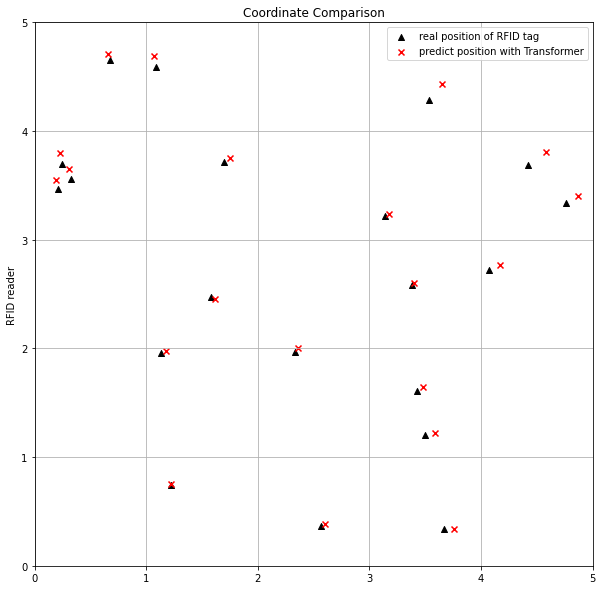

In [12]:
plt.figure(figsize=[10, 10])
plt.xlim((0, 5))
plt.ylim((0, 5))
plt.ylabel('RFID reader')
plt.title('Coordinate Comparison')
# 画图-标准坐标
plt.scatter(y_teacher[:, 0], y_teacher[:, 1], c='black', marker='^', label='real position of RFID tag')

# 画图-预测EA坐标
plt.scatter(pxy[:, 0], pxy[:, 1], c='red', marker='x', label = 'predict position with Transformer')

plt.legend()
plt.grid('True')
plt.savefig('./result/compare_coordinate_teacher.jpg', dpi=750, bbox_inches = 'tight')

### 定义学生模型-GRU模型

In [7]:
class StudentGRU(nn.Module):
    def __init__(self):
        super(StudentGRU, self).__init__()
        self.time_step = 50
        self.x_dim = 1
        self.h_dim = 60
        self.gru_layers = 1
        self.GRU_layer = nn.GRU(self.x_dim, self.h_dim, self.gru_layers, batch_first=True)
        self.FC = nn.Linear(self.h_dim, 2)


    def forward(self, x):
        batch, time_step, x_dim = x.size()
        h0 = torch.zeros((self.gru_layers, batch, self.h_dim)).to(device)
        output, hn = self.GRU_layer(x, h0)
        res = hn.squeeze(0)
        res = self.FC(res)
        return res

### 学生模型设置

In [8]:
# 从头先训练一下学生模型
model = StudentGRU().to(device)
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### 学生模型信息

In [9]:
# 输出学生模型的参数信息-1w参数
cp.get_summary(model, input_size=None)

torchinfo信息如下：
Layer (type:depth-idx)                   Param #
StudentGRU                               --
├─GRU: 1-1                               11,340
├─Linear: 1-2                            122
Total params: 11,462
Trainable params: 11,462
Non-trainable params: 0


### 学生模型训练

In [16]:
%%time
best_loss = 100000
best_epoch = 0
for epoch in range(100):
    epoch_loss = 0
    for X, y in train_data_loader:
        outputs = model(X.unsqueeze(2))
        loss = criterion(outputs, y)
        loss_num = loss.item()
        epoch_loss += loss_num
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, './result/student_weight.pth')

    print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(epoch_loss))

# 打印最佳的结果
print('best_loss::|',best_loss,'---best_epoch::|',best_epoch)


Epoch: 0001 loss = 126.615397
Epoch: 0002 loss = 46.508901
Epoch: 0003 loss = 37.153317
Epoch: 0004 loss = 32.349354
Epoch: 0005 loss = 27.534442
Epoch: 0006 loss = 23.283589
Epoch: 0007 loss = 21.353673
Epoch: 0008 loss = 20.379462
Epoch: 0009 loss = 19.590748
Epoch: 0010 loss = 18.844475
Epoch: 0011 loss = 17.974698
Epoch: 0012 loss = 17.001275
Epoch: 0013 loss = 15.827827
Epoch: 0014 loss = 14.640810
Epoch: 0015 loss = 13.462836
Epoch: 0016 loss = 12.385943
Epoch: 0017 loss = 11.912295
Epoch: 0018 loss = 11.581795
Epoch: 0019 loss = 10.188987
Epoch: 0020 loss = 9.653889
Epoch: 0021 loss = 9.115663
Epoch: 0022 loss = 9.015367
Epoch: 0023 loss = 8.286433
Epoch: 0024 loss = 8.108266
Epoch: 0025 loss = 7.633524
Epoch: 0026 loss = 7.092835
Epoch: 0027 loss = 6.854542
Epoch: 0028 loss = 6.765924
Epoch: 0029 loss = 6.432175
Epoch: 0030 loss = 6.272533
Epoch: 0031 loss = 5.940240
Epoch: 0032 loss = 5.780853
Epoch: 0033 loss = 6.548049
Epoch: 0034 loss = 5.772249
Epoch: 0035 loss = 5.191743


### 学生模型评估

In [10]:
model = StudentGRU()
# 暂存不加蒸馏学生模型为student_model
student_model = model

model.load_state_dict(torch.load('./result/student_weight.pth'))
model.eval()

pxy = model(X_test.unsqueeze(2))
pxy = pxy.cpu().detach().numpy()
# 计算指标
mae = mean_absolute_error(y_test, pxy)
mse = mean_squared_error(y_test, pxy)
rmse = mse ** 0.5
evs = explained_variance_score(y_test, pxy)
r2 = r2_score(y_test, pxy)

mmax = 0
mmin = 10000
for i in range(len(pxy)):
    mmax = max(mean_absolute_error(y_test[i], pxy[i]), mmax)
    mmin = min(mean_absolute_error(y_test[i], pxy[i]), mmin)

print({'mae': mae, 'mse': mse, 'rmse': rmse, 'evs': evs, 'r2': r2, 'mmax': mmax, 'mmin': mmin})


RuntimeError: Error(s) in loading state_dict for StudentGRU:
	Missing key(s) in state_dict: "GRU_layer.weight_ih_l0", "GRU_layer.weight_hh_l0", "GRU_layer.bias_ih_l0", "GRU_layer.bias_hh_l0", "FC.weight", "FC.bias". 
	Unexpected key(s) in state_dict: "embedding_enc.weight", "embedding_enc.bias", "embedding_dec.weight", "embedding_dec.bias", "Transformer_layer.encoder.layers.0.self_attn.in_proj_weight", "Transformer_layer.encoder.layers.0.self_attn.in_proj_bias", "Transformer_layer.encoder.layers.0.self_attn.out_proj.weight", "Transformer_layer.encoder.layers.0.self_attn.out_proj.bias", "Transformer_layer.encoder.layers.0.linear1.weight", "Transformer_layer.encoder.layers.0.linear1.bias", "Transformer_layer.encoder.layers.0.linear2.weight", "Transformer_layer.encoder.layers.0.linear2.bias", "Transformer_layer.encoder.layers.0.norm1.weight", "Transformer_layer.encoder.layers.0.norm1.bias", "Transformer_layer.encoder.layers.0.norm2.weight", "Transformer_layer.encoder.layers.0.norm2.bias", "Transformer_layer.encoder.norm.weight", "Transformer_layer.encoder.norm.bias", "Transformer_layer.decoder.layers.0.self_attn.in_proj_weight", "Transformer_layer.decoder.layers.0.self_attn.in_proj_bias", "Transformer_layer.decoder.layers.0.self_attn.out_proj.weight", "Transformer_layer.decoder.layers.0.self_attn.out_proj.bias", "Transformer_layer.decoder.layers.0.multihead_attn.in_proj_weight", "Transformer_layer.decoder.layers.0.multihead_attn.in_proj_bias", "Transformer_layer.decoder.layers.0.multihead_attn.out_proj.weight", "Transformer_layer.decoder.layers.0.multihead_attn.out_proj.bias", "Transformer_layer.decoder.layers.0.linear1.weight", "Transformer_layer.decoder.layers.0.linear1.bias", "Transformer_layer.decoder.layers.0.linear2.weight", "Transformer_layer.decoder.layers.0.linear2.bias", "Transformer_layer.decoder.layers.0.norm1.weight", "Transformer_layer.decoder.layers.0.norm1.bias", "Transformer_layer.decoder.layers.0.norm2.weight", "Transformer_layer.decoder.layers.0.norm2.bias", "Transformer_layer.decoder.layers.0.norm3.weight", "Transformer_layer.decoder.layers.0.norm3.bias", "Transformer_layer.decoder.norm.weight", "Transformer_layer.decoder.norm.bias", "FC_layer.weight", "FC_layer.bias". 

### 学生模型定位效果可视化

In [12]:
y_student = y_test[:20]
pxy = pxy[:20]
print(pxy.shape())
coor1 = pd.DataFrame(y_student)
coor1.columns = ['X', 'y']

coor2 = pd.DataFrame(pxy)
coor2.columns = ['PX', 'Py']

coor = pd.concat([coor1, coor2], axis=1)
coor.to_csv('./result/coordinate_all_student.csv')
coor

NameError: name 'pxy' is not defined

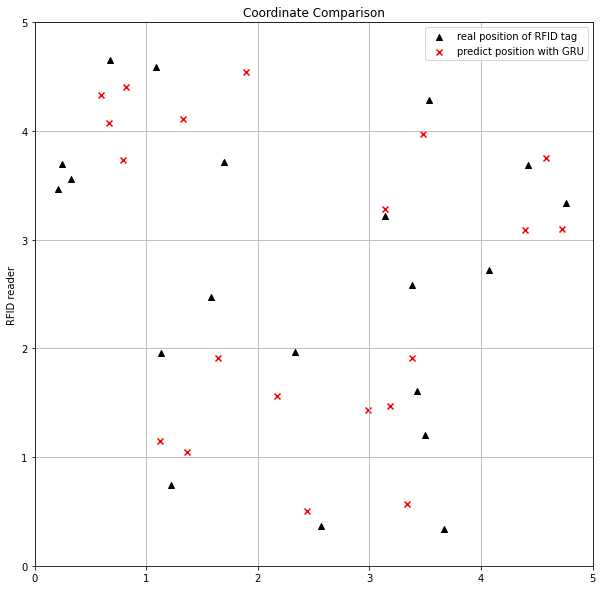

In [19]:
plt.figure(figsize=[10, 10])
plt.xlim((0, 5))
plt.ylim((0, 5))
plt.ylabel('RFID reader')
plt.title('Coordinate Comparison')
# 画图-标准坐标
plt.scatter(y_student[:, 0], y_student[:, 1], c='black', marker='^', label='real position of RFID tag')

# 画图-预测EA坐标
plt.scatter(pxy[:, 0], pxy[:, 1], c='red', marker='x', label = 'predict position with GRU')

plt.legend()
plt.grid('True')
plt.savefig('./result/compare_coordinate_student.jpg', dpi=750, bbox_inches = 'tight')

### 知识蒸馏准备与设置

In [20]:
# 准备预训练好的教师模型
teacher_model.eval()

# 准备新的学生模型
model = StudentGRU().to(device)

# 蒸馏温度
T = 7

# 蒸馏参数设置
# hard_loss
hard_loss = nn.MSELoss()
# hard_loss权重
alpha = 0.3
# soft_loss kl散度
soft_loss = nn.KLDivLoss(reduction='batchmean')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### 知识蒸馏训练

In [21]:
%%time
best_loss = 100000
best_epoch = 0
for epoch in range(50):
    epoch_loss = 0
    for X, y in train_data_loader:
        X, y = X.to(device), y.to(device)
        # 教师模型预测
        with torch.no_grad():
            teacher_outputs = teacher_model(X, y)
        # 学生模型预测
        student_outputs = model(X.unsqueeze(2))
        student_loss = hard_loss(student_outputs, y)
        # 计算蒸馏后的预测结果及soft_loss
        distillation_loss = soft_loss(
            F.softmax(student_outputs/T, dim=1),
            F.softmax(teacher_outputs/T, dim=1)
        )
        # 将 hard_loss 和 soft_loss 加权求和
        loss = alpha * student_loss + (1-alpha) * distillation_loss
        # 反向传播,优化权重
        optimizer.zero_grad()
        epoch_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, './result/distillation_weight.pth')

    print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(epoch_loss))

# 打印最佳的结果
print('best_loss::|',best_loss,'---best_epoch::|',best_epoch)


/Users/frank/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/autograd/__init__.py:173: UserWarning: An output with one or more elements was resized since it had shape [100, 2], which does not match the required output shape [1, 100, 2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1656352448001/work/aten/src/ATen/native/Resize.cpp:24.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0001 loss = 21.550274
Epoch: 0002 loss = 10.502714
Epoch: 0003 loss = 9.124789
Epoch: 0004 loss = 7.747394
Epoch: 0005 loss = 6.248393
Epoch: 0006 loss = 5.433194
Epoch: 0007 loss = 4.983259
Epoch: 0008 loss = 4.645968
Epoch: 0009 loss = 4.336763
Epoch: 0010 loss = 4.096585
Epoch: 0011 loss = 3.765023
Epoch: 0012 loss = 3.317800
Epoch: 0013 loss = 2.799927
Epoch: 0014 loss = 2.322700
Epoch: 0015 loss = 1.919871
Epoch: 0016 loss = 1.870934
Epoch: 0017 loss = 1.323074
Epoch: 0018 loss = 1.245937
Epoch: 0019 loss = 1.004147
Epoch: 0020 loss = 0.918189
Epoch: 0021 loss = 0.801783
Epoch: 0022 loss = 0.874907
Epoch: 0023 loss = 0.665673
Epoch: 0024 loss = 0.508456
Epoch: 0025 loss = 0.431734
Epoch: 0026 loss = 0.519700
Epoch: 0027 loss = 0.346793
Epoch: 0028 loss = 0.477123
Epoch: 0029 loss = 0.232550
Epoch: 0030 loss = 0.345846
Epoch: 0031 loss = 0.198594
Epoch: 0032 loss = 0.484500
Epoch: 0033 loss = 0.078326
Epoch: 0034 loss = 0.149256
Epoch: 0035 loss = 0.074356
Epoch: 0036 loss =

### 蒸馏模型评估

In [22]:
model = StudentGRU()
model.load_state_dict(torch.load('./result/distillation_weight.pth'))
model.eval()

pxy = model(X_test.unsqueeze(2))
pxy = pxy.cpu().detach().numpy()

# 计算指标
mae = mean_absolute_error(y_test, pxy)
mse = mean_squared_error(y_test, pxy)
rmse = mse ** 0.5
evs = explained_variance_score(y_test, pxy)
r2 = r2_score(y_test, pxy)

mmax = 0
mmin = 10000
for i in range(len(pxy)):
    mmax = max(mean_absolute_error(y_test[i], pxy[i]), mmax)
    mmin = min(mean_absolute_error(y_test[i], pxy[i]), mmin)

print({'mae': mae, 'mse': mse, 'rmse': rmse, 'evs': evs, 'r2': r2, 'mmax': mmax, 'mmin': mmin})


{'mae': 0.36821693, 'mse': 0.23866627, 'rmse': 0.48853481575311153, 'evs': 0.8913758397102356, 'r2': 0.8829420033912048, 'mmax': 1.409583, 'mmin': 0.022428513}


### 蒸馏模型定位效果可视化

In [23]:
y_distill = y_test[:20]
pxy = pxy[:20]
coor1 = pd.DataFrame(y_distill)
coor1.columns = ['X', 'y']

coor2 = pd.DataFrame(pxy)
coor2.columns = ['PX', 'Py']

coor = pd.concat([coor1, coor2], axis=1)
coor.to_csv('./result/coordinate_all_distill.csv')
coor

,X,y,PX,Py
0,0.21,3.47,1.031719,3.814757
1,1.13,1.96,1.230146,0.857174
2,3.38,2.58,3.237440,2.034766
3,4.07,2.72,4.381285,3.149054
4,1.58,2.47,1.825895,1.861442
5,3.43,1.61,3.069871,1.526877
6,1.22,0.74,1.483578,0.866910
7,2.33,1.97,2.332991,1.319793
8,0.33,3.56,0.824599,3.927056
9,3.53,4.28,3.555741,3.898636


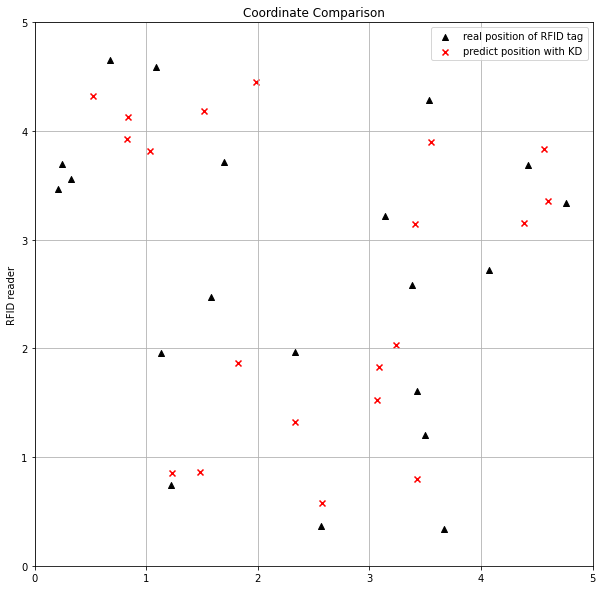

In [24]:
plt.figure(figsize=[10, 10])
plt.xlim((0, 5))
plt.ylim((0, 5))
plt.ylabel('RFID reader')
plt.title('Coordinate Comparison')
# 画图-标准坐标
plt.scatter(y_distill[:, 0], y_distill[:, 1], c='black', marker='^', label='real position of RFID tag')

# 画图-预测EA坐标
plt.scatter(pxy[:, 0], pxy[:, 1], c='red', marker='x', label = 'predict position with KD')

plt.legend()
plt.grid('True')
plt.savefig('./result/compare_coordinate_distill.jpg', dpi=750, bbox_inches = 'tight')

### 定义问题类

In [19]:
class MOEA(ea.Problem):
    def __init__(self, train_data_loader, test_data_loader):
        name = 'MOEA'
        M = 1 # 初始化M（目标维数）
        maxormins = [-1] # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = 2 # 初始化Dim（决策变量维数）
        varTypes = np.array([0] * Dim) # 初始化varTypes 0-连续
        lb = [5, 0.1] # 决策变量下界
        ub = [10, 0.9] # 决策变量上界
        lbin = [1] * Dim # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1] * Dim # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)
        # 数据设置
        self.train_data_loader = train_data_loader
        self.test_data_loader = test_data_loader


    # 目标函数，采用多线程加速计算
    def aimFunc(self, pop):
        Vars = pop.Phen # 得到决策变量矩阵
        # print(Vars)
        pop.ObjV = np.zeros((pop.sizes, 1)) # 初始化种群个体目标函数值列向量
        def subAimFunc(i):
            epochs, alpha = int(Vars[i, 0]), float(Vars[i, 1])
            print(epochs, alpha)
            final_loss = 0
            for epoch in range(epochs):
                for data,targets in tqdm(train_data_loader):
                    data, targets = data.to(device), targets.to(device)
                    # 教师模型预测
                    with torch.no_grad():
                        teacher_outputs = teacher_model(data)
                    # 学生模型预测
                    student_outputs = model(data)
                    student_loss = hard_loss(student_outputs, targets)
                    # 计算蒸馏后的预测结果及soft_loss
                    distillation_loss = soft_loss(
                        F.softmax(student_outputs/T, dim=1),
                        F.softmax(teacher_outputs/T, dim=1)
                    )
                    # 将 hard_loss 和 soft_loss 加权求和
                    loss = alpha * student_loss + (1-alpha) * distillation_loss
                    final_loss = loss.item()
                    # 反向传播,优化权重
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            pop.ObjV[i] = final_loss # 最小化最终的损失作为目标函数
        pool = ThreadPool(processes=2) # 设置池的大小
        pool.map(subAimFunc, list(range(pop.sizes))) # 散列种群每个个体进行加速计算


    # 代入优化后的参数先训练再对测试集进行检验，计算指标
    def test(self, epochs, alpha):
        for epoch in range(epochs):
            for data,targets in tqdm(train_data_loader):
                data, targets = data.to(device), targets.to(device)
                # 教师模型预测
                with torch.no_grad():
                    teacher_outputs = teacher_model(data)
                # 学生模型预测
                student_outputs = model(data)
                student_loss = hard_loss(student_outputs, targets)
                # 计算蒸馏后的预测结果及soft_loss
                distillation_loss = soft_loss(
                    F.softmax(student_outputs/T, dim=1),
                    F.softmax(teacher_outputs/T, dim=1)
                )
                # 将 hard_loss 和 soft_loss 加权求和
                loss = alpha * student_loss + (1-alpha) * distillation_loss
                # 反向传播,优化权重
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # 测试集上评估性能
            model.eval()
            num_correct = 0
            num_samples = 0

            with torch.no_grad():
                for x,y in test_data_loader:
                    x, y = x.to(device), y.to(device)
                    outputs = model(x)
                    pred = outputs.max(1).indices
                    num_correct += (pred == y).sum()
                    num_samples += pred.size(0)
                acc = (num_correct/num_samples).item()

            model.train()
            print("Epoch:{}\t Accuracy:{:4f}".format(epoch + 1, acc))

        torch.save(model.state_dict(), "./models/moea_distillation.pth")



### 参数调优

In [20]:
"""===============================实例化问题对象==========================="""

problem = MOEA(train_data_loader, test_data_loader) # 生成问题对象

"""=================================种群设置==============================="""

Encoding = 'RI'       # 编码方式
NIND = 10             # 种群规模
Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges, problem.borders) # 创建区域描述器
population = ea.Population(Encoding, Field, NIND) # 实例化种群对象（此时种群还没被初始化，仅仅是完成种群对象的实例化）

"""===============================算法参数设置============================="""

myAlgorithm = ea.soea_DE_rand_1_bin_templet(problem, population) # 实例化一个算法模板对象
myAlgorithm.MAXGEN = 10 # 最大进化代数
myAlgorithm.trappedValue = 1e-6 # “进化停滞”判断阈值
myAlgorithm.maxTrappedCount = 10 # 进化停滞计数器最大上限值，如果连续maxTrappedCount代被判定进化陷入停滞，则终止进化
myAlgorithm.logTras = 1  # 设置每隔多少代记录日志，若设置成0则表示不记录日志
myAlgorithm.verbose = True  # 设置是否打印输出日志信息
myAlgorithm.drawing = 1  # 设置绘图方式（0：不绘图；1：绘制结果图；2：绘制目标空间过程动画；3：绘制决策空间过程动画）

"""===========================调用算法模板进行种群进化======================="""

[BestIndi, population] = myAlgorithm.run()  # 执行算法模板，得到最优个体以及最后一代种群
BestIndi.save()  # 把最优个体的信息保存到文件中

"""==================================输出结果============================="""

print('用时：%f 秒' % myAlgorithm.passTime)
print('评价次数：%d 次' % myAlgorithm.evalsNum)
if BestIndi.sizes != 0:
    print('最优的目标函数值为：%s' % BestIndi.ObjV[0][0])
    print('最优的控制变量值为：')
    for i in range(BestIndi.Phen.shape[1]):
        print(BestIndi.Phen[0, i])
else:
    print('没找到可行解。')

"""=================================检验结果==============================="""

problem.test(epochs= int(BestIndi.Phen[0][0]), alpha= float(BestIndi.Phen[0][1]))


7 0.3189171239733696


6 0.2855765145272017


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 2/938 [00:00<00:54, 17.05it/s]


6 0.8424268286675215



  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 2/938 [00:00<00:52, 17.78it/s]

  0%|          | 4/938 [00:00<00:51, 18.15it/s]

 94%|█████████▎| 878/938 [00:08<00:00, 102.62it/s]


  1%|          | 9/938 [00:00<00:48, 19.11it/s]]


6 0.8656420316547155


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:05, 14.39it/s]]


9 0.6277091335505247


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 4/938 [00:00<00:25, 37.06it/s]]

  1%|          | 10/938 [00:00<00:26, 34.80it/s]


  3%|▎         | 31/938 [00:00<00:23, 38.58it/s]

  4%|▍         | 38/938 [00:01<00:19, 45.81it/s]

  5%|▍         | 46/938 [00:01<00:16, 54.51it/s]

  6%|▌         | 54/938 [00:01<00:14, 61.32it/s]

  7%|▋         | 65/938 [00:01<00:11, 74.37it/s]

  8%|▊         | 76/938 [00:01<00:10, 83.75it/s]

  9%|▉         | 86/938 [00:01<00:09, 88.29it/s]

 10%|█         | 96/938 [00:01<00:09, 89.71it/s]

 11%|█▏        | 106/938 [00:01<00:09, 85.26it/s]

 12%|█▏        | 116/938 [00:01<00:09, 87.53it/s]

 13%|█▎        | 125/938 [00:02<00:09, 87.56it/s]

 14%|█▍        | 134/938 [00:02<00:09, 86.86it/s]

 15%|█▌        | 143/938 [00:02<00:09, 87.52it/s]

 16%|█▌        | 152/938 [00:02<00:09, 86.56it/s]

 17%|█▋        | 163/938 [00:02<00:08, 92.49it/s]

 19%|█▊        | 174/938 [00:02<00:08, 95.28it/s]

 20%|█▉        | 184/938 [00:02<00:08, 92.35it/s]


8 0.2740337282419205


100%|██████████| 938/938 [00:08<00:00, 116.82it/s]


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [20, 10]], which is output 0 of AsStridedBackward0, is at version 23416; expected version 23415 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).